In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pgmpy.models import BayesianNetwork, LinearGaussianBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, ExpectationMaximization, BayesianEstimator
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, BDsScore
import matplotlib.pyplot as plt
from pgmpy.inference import VariableElimination
import networkx as nx

c:\Users\suvar\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def visualise(model, pos, projectile_color="skyblue", interceptor_color="lightcoral"):
    edges = model.edges()

    # Create separate lists for intra-time slice and inter-time slice edges
    intra_time_slice_edges = []
    inter_time_slice_edges = []

    for edge in edges:
        if abs(int(edge[0][-1]) - int(edge[1][-1])) == 0:
            intra_time_slice_edges.append(edge)
        else:
            inter_time_slice_edges.append(edge)

    # Create a directed graph object
    G = nx.DiGraph()

    # Add edges to the graph
    G.add_edges_from(edges)

    # Create a color map based on node type
    color_map = []
    for node in G.nodes():
        if "FP" in node:
            color_map.append("gray")
        elif "P" == node[0]:
            color_map.append(projectile_color)
        elif "I_" in node:
            color_map.append(interceptor_color)
        else:
            color_map.append("gray")  # Default color for any other nodes

    # Plot the graph with custom positions and colors
    plt.figure(figsize=(20, 12))

    # Draw edges first to ensure arrowheads are not covered
    nx.draw_networkx_edges(
        G, pos, edgelist=intra_time_slice_edges, arrows=True,
        edge_color='black', style='solid', arrowsize=15, arrowstyle='-|>',
        min_source_margin=10, min_target_margin=15  # Increase margins to make arrows shorter
    )

    nx.draw_networkx_edges(
        G, pos, edgelist=inter_time_slice_edges, arrows=True,
        edge_color='black', style=(0, (5, 10)), arrowsize=15, arrowstyle='-|>',
        min_source_margin=10, min_target_margin=15  # Increase margins to make arrows shorter
    )

    # Draw nodes after edges
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color=color_map)

    nx.draw_networkx_labels(G, pos, font_size=8, font_weight="bold")

    plt.title("Bayesian Network Graph")
    plt.show()

In [3]:
# Define positions manually for x and y positions
pos = {}

for i in range(6):
    if i % 2 == 0:
        # Projectile nodes positions (lower row)
        pos[f'P_FP_x{i}'] = (i * 3 - 1 - 1, 0)          # Final position x
        pos[f'P_FP_y{i}'] = (i * 3 - 1, 0)              # Final position y
        pos[f'P_V{i}'] = (i * 3 + 1 - 1, -1)            # Velocity
        pos[f'P_IP_x{i}'] = (i * 3 - 1 - 1, -1)         # Initial position x
        pos[f'P_IP_y{i}'] = (i * 3 - 1, -1)             # Initial position y

        # Interceptor nodes positions (upper row)
        pos[f'I_FP_x{i}'] = (i * 3 - 1, 3)          # Final position x
        pos[f'I_FP_y{i}'] = (i * 3, 3)              # Final position y
        pos[f'I_V{i}'] = (i * 3 + 1, 2)             # Velocity
        pos[f'I_IP_x{i}'] = (i * 3 - 1, 2)          # Initial position x
        pos[f'I_IP_y{i}'] = (i * 3, 2)              # Initial position y
    else:
        # Projectile nodes positions (lower row)
        pos[f'P_FP_x{i}'] = (i * 3 - 1 - 1, -1)         # Final position x
        pos[f'P_FP_y{i}'] = (i * 3 - 1, -1)             # Final position y
        pos[f'P_V{i}'] = (i * 3 + 1 - 1, -2)            # Velocity
        pos[f'P_IP_x{i}'] = (i * 3 - 1 - 1, -2)         # Initial position x
        pos[f'P_IP_y{i}'] = (i * 3 - 1, -2)             # Initial position y

        # Interceptor nodes positions (upper row)
        pos[f'I_FP_x{i}'] = (i * 3 - 1, 4)          # Final position x
        pos[f'I_FP_y{i}'] = (i * 3, 4)              # Final position y
        pos[f'I_V{i}'] = (i * 3 + 1, 3)             # Velocity
        pos[f'I_IP_x{i}'] = (i * 3 - 1, 3)          # Initial position x
        pos[f'I_IP_y{i}'] = (i * 3, 3)              # Initial position y



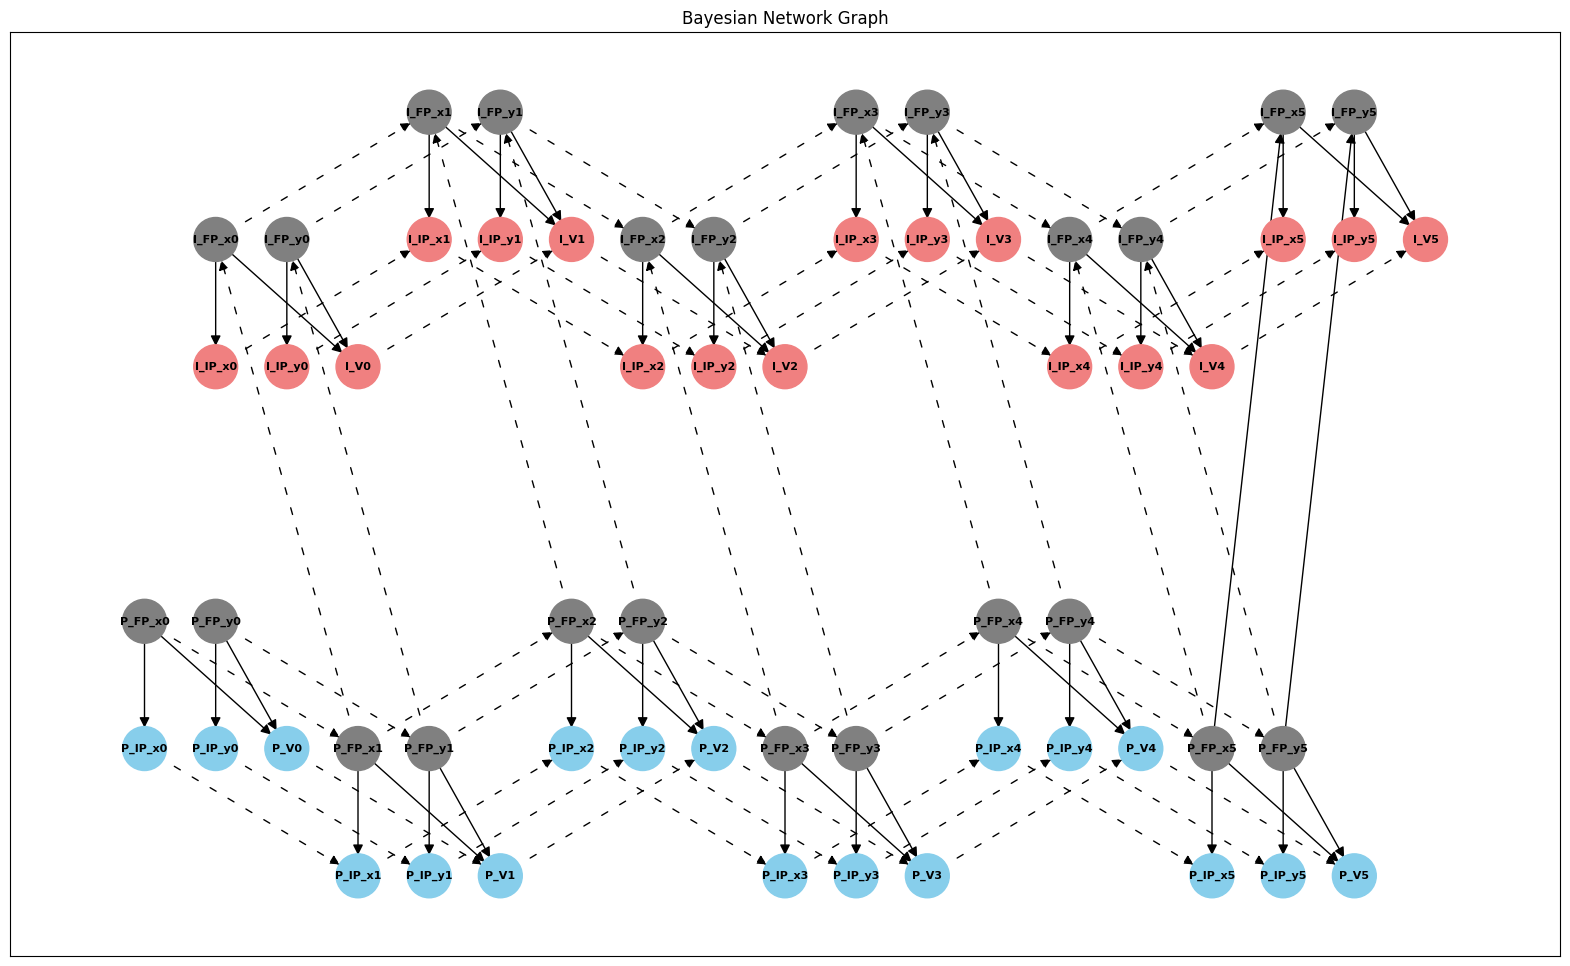

In [4]:
from pgmpy.factors.continuous import LinearGaussianCPD
from pgmpy.models import LinearGaussianBayesianNetwork

# Initialize the Bayesian Network model
GT = LinearGaussianBayesianNetwork()

for i in range(6):
    # Add nodes for final position (FP), velocity (V), and initial position (IP)
    GT.add_nodes_from([
        f'P_FP_x{i}', f'P_FP_y{i}', f'P_V{i}', f'P_IP_x{i}', f'P_IP_y{i}',  # Projectile nodes
        f'I_FP_x{i}', f'I_FP_y{i}', f'I_V{i}', f'I_IP_x{i}', f'I_IP_y{i}'   # Interceptor nodes
    ])
    
    # Add edges within each time slice for both x and y positions
    GT.add_edges_from([
        (f'P_FP_x{i}' , f'P_IP_x{i}'),  # Initial position (x) influences final position (x)
        (f'P_FP_x{i}' , f'P_V{i}'),     # Velocity influences final position (x)
        (f'P_FP_y{i}' , f'P_IP_y{i}'),  # Initial position (y) influences final position (y)
        (f'P_FP_y{i}', f'P_V{i}'),     # Velocity influences final position (y)
        
        (f'I_FP_x{i}' , f'I_IP_x{i}'),  # Interceptor: Initial position (x) influences final position (x)
        (f'I_FP_x{i}' , f'I_V{i}'),     # Velocity influences final position (x)
        (f'I_FP_y{i}' , f'I_IP_y{i}'),  # Initial position (y) influences final position (y)
        (f'I_FP_y{i}' , f'I_V{i}')      # Velocity influences final position (y)
    ])

    if i < 5:
        # Connect corresponding nodes between time slices for projectile and interceptor
        GT.add_edges_from([
            # Projectile time slice connections for x and y positions
            (f'P_FP_x{i}', f'P_FP_x{i + 1}'),
            (f'P_IP_x{i}', f'P_IP_x{i + 1}'),
            (f'P_FP_y{i}', f'P_FP_y{i + 1}'),
            (f'P_IP_y{i}', f'P_IP_y{i + 1}'),
            (f'P_V{i}', f'P_V{i + 1}'),

            # Interceptor time slice connections for x and y positions
            (f'I_FP_x{i}', f'I_FP_x{i + 1}'),
            (f'I_IP_x{i}', f'I_IP_x{i + 1}'),
            (f'I_FP_y{i}', f'I_FP_y{i + 1}'),
            (f'I_IP_y{i}', f'I_IP_y{i + 1}'),
            (f'I_V{i}', f'I_V{i + 1}')
        ])
        
        # Edge between projectile and interceptor across time slices
        GT.add_edges_from([
            (f'P_FP_x{i + 1}', f'I_FP_x{i}'),
            (f'P_FP_y{i + 1}', f'I_FP_y{i}')
        ])

# Final edges to ensure convergence at the last time slice
GT.add_edges_from([
    (f'P_FP_x{5}', f'I_FP_x{5}'),
    (f'P_FP_y{5}', f'I_FP_y{5}')
])


visualise(GT, pos)




In [5]:
def fit_cpd_for_node(node, parents, data):
    required_columns = [node] + parents

    # Ensure all required columns are in the data
    missing_columns = [col for col in required_columns if col not in data.columns]
    if missing_columns:
        raise KeyError(f"Missing columns in data: {missing_columns}")
    
    # Creating the correct column names and structure for fitting
    node_data_before = data[required_columns].copy()
    node_data_before.columns = ["(Y|X)" if col == node else col for col in node_data_before.columns]

    # Add noise to all 0.0 values in the DataFrame
    noise_std = 1e-5 
    node_data = node_data_before.map(lambda x: x + np.random.normal(0, noise_std) if x == 0.0 else x)

    print("Fitting CPD for node:", node)
    print("Parents:", parents)
    print("Data being used for fit:")
    print(node_data.head())  # Print the first few rows of node_data

    if parents:
        # Initialize a Linear Gaussian CPD object
        cpd = LinearGaussianCPD(
            variable=node,
            evidence_mean=[0] * (len(parents) + 1),  # Initial guess for betas
            evidence_variance=1,  # Initial variance guess
            evidence=parents
        )
        
        node = "(Y|X)"
        print(f"Node: {node} \n")
        print("-"*50)
        # Fit the CPD using MLE
        beta, variance = cpd.fit(node_data, states=[node] + parents, estimator="MLE")
        return cpd
    else:
        # If no parents, fit a univariate Gaussian
        mean = data[node].mean()
        variance = data[node].var()
        return LinearGaussianCPD(variable=node, evidence_mean=[mean], evidence_variance=variance)




data = pd.read_csv('trajectory_data.csv')

# Assuming you have a pandas DataFrame `data` with all necessary columns.
for i in range(6):
    if i == 0:
        # Fit Projectile CPDs for x and y positions
        cpd_P_FP_x = fit_cpd_for_node(f'P_FP_x{i}', [], data)
        cpd_P_FP_y = fit_cpd_for_node(f'P_FP_y{i}', [], data)
        cpd_P_V = fit_cpd_for_node(f'P_V{i}', [f'P_FP_x{i}', f'P_FP_y{i}'], data)
        cpd_P_IP_x = fit_cpd_for_node(f'P_IP_x{i}', [f'P_FP_x{i}'], data)
        cpd_P_IP_y = fit_cpd_for_node(f'P_IP_y{i}', [f'P_FP_y{i}'], data)
    else:
        # Fit Projectile CPDs for x and y positions
        cpd_P_FP_x = fit_cpd_for_node(f'P_FP_x{i}', [f'P_FP_x{i - 1}'], data)
        cpd_P_FP_y = fit_cpd_for_node(f'P_FP_y{i}', [f'P_FP_y{i - 1}'], data)
        cpd_P_V = fit_cpd_for_node(f'P_V{i}', [f'P_V{i - 1}',f'P_FP_x{i}', f'P_FP_y{i}'], data)
        cpd_P_IP_x = fit_cpd_for_node(f'P_IP_x{i}', [f'P_FP_x{i}', f'P_IP_x{i - 1}'], data)
        cpd_P_IP_y = fit_cpd_for_node(f'P_IP_y{i}', [f'P_FP_y{i}', f'P_IP_y{i - 1}'], data)

    # Add fitted CPDs to the network
    GT.add_cpds(cpd_P_FP_x, cpd_P_FP_y, cpd_P_V, cpd_P_IP_x, cpd_P_IP_y)

# Fit and add Interceptor CPDs
for i in range(6):
    if i == 0:
        cpd_I_FP_x = fit_cpd_for_node(f'I_FP_x{i}', [f'P_FP_x{i+1}'], data)
        cpd_I_FP_y = fit_cpd_for_node(f'I_FP_y{i}', [f'P_FP_y{i+1}'], data)
        cpd_I_V = fit_cpd_for_node(f'I_V{i}', [f'I_FP_x{i}', f'I_FP_y{i}'], data)
        cpd_I_IP_x = fit_cpd_for_node(f'I_IP_x{i}', [f'I_FP_x{i}'], data)
        cpd_I_IP_y = fit_cpd_for_node(f'I_IP_y{i}', [f'I_FP_y{i}'], data)
    else:
        if i < 5:
            cpd_I_FP_x = fit_cpd_for_node(f'I_FP_x{i}', [f'P_FP_x{i+1}', f'I_FP_x{i - 1}'], data)
            cpd_I_FP_y = fit_cpd_for_node(f'I_FP_y{i}', [f'P_FP_y{i+1}', f'I_FP_y{i - 1}'], data)
        else:
            cpd_I_FP_x = fit_cpd_for_node(f'I_FP_x{i}', [f'I_FP_x{i - 1}', f'P_FP_x{i}'], data)
            cpd_I_FP_y = fit_cpd_for_node(f'I_FP_y{i}', [f'I_FP_y{i - 1}', f'P_FP_y{i}'], data)

        cpd_I_V = fit_cpd_for_node(f'I_V{i}', [f'I_V{i - 1}',f'I_FP_x{i}',  f'I_FP_y{i}'], data)
        cpd_I_IP_x = fit_cpd_for_node(f'I_IP_x{i}', [f'I_FP_x{i}', f'I_IP_x{i - 1}'], data)
        cpd_I_IP_y = fit_cpd_for_node(f'I_IP_y{i}', [f'I_FP_y{i}', f'I_IP_y{i - 1}'], data)

    # Add fitted CPDs to the network
    GT.add_cpds(cpd_I_FP_x, cpd_I_FP_y, cpd_I_V, cpd_I_IP_x, cpd_I_IP_y)



Fitting CPD for node: P_FP_x0
Parents: []
Data being used for fit:
         (Y|X)
0   985.585285
1   989.213765
2   987.866523
3  1004.230154
4   986.996474
Fitting CPD for node: P_FP_y0
Parents: []
Data being used for fit:
        (Y|X)
0  107.750168
1   85.668115
2   79.230251
3   88.664051
4  136.063326
Fitting CPD for node: P_V0
Parents: ['P_FP_x0', 'P_FP_y0']
Data being used for fit:
       (Y|X)      P_FP_x0     P_FP_y0
0  19.287119   985.585285  107.750168
1  24.792100   989.213765   85.668115
2  19.296740   987.866523   79.230251
3  17.238066  1004.230154   88.664051
4  16.704131   986.996474  136.063326
Node: (Y|X) 

--------------------------------------------------
Fitting CPD for node: P_IP_x0
Parents: ['P_FP_x0']
Data being used for fit:
        (Y|X)      P_FP_x0
0  114.720778   985.585285
1   97.446460   989.213765
2  178.513058   987.866523
3  167.840181  1004.230154
4   81.735982   986.996474
Node: (Y|X) 

--------------------------------------------------
Fitting CPD 

In [6]:
# Validation
if GT.check_model():
    print("The model is valid!")
else:
    print("The model is not valid. Please check the CPDs and network structure.")


The model is valid!


In [7]:
import pandas as pd
import numpy as np

# Load the test data
test_data = pd.read_csv("trajectory_test_data.csv")

def predict_with_linear_gaussian_cpd(evidence, cpd):
    """
    Predict values using a Linear Gaussian CPD.
    
    Parameters
    ----------
    evidence: dict
        Dictionary with observed values.
    cpd: LinearGaussianCPD
        The CPD object to use for prediction.
    
    Returns
    -------
    float
        Predicted value for the query variable.
    """
    print(cpd)

    if cpd is None:
        # Return a fallback value if CPD is not fitted
        print(f"CPD not fitted for node. Returning default value.")
        return 0.0  # Replace with domain-specific default if needed

    if not hasattr(cpd, 'beta') or cpd.beta is None:
        # The node has no parents, return its mean value
        print(f"Node has no parents. Using mean for prediction.")
        return cpd.mean
    
    beta = cpd.beta
    mean_vector = cpd.mean
    variance = cpd.variance
    print(f"Beta values: {beta}")
    print(f"Mean vals: {mean_vector}")
    print(f"Variance: {variance}")
    print(f"Evidence required: {cpd.evidence}")
    evidence_vals = [evidence[var] for var in cpd.evidence]
    evidence_vals_array = np.array([val.flatten() if isinstance(val, np.ndarray) else [val] for val in evidence_vals])
    print(f"Evidence vals: {evidence_vals_array}")
    print(f"Coeffecients to be used: {beta[1:]}")
    predicted_mean = beta[0] + np.dot(
        evidence_vals_array.flatten(),
        beta[1:]
    )
    return predicted_mean

# List to store predictions for each row in test_data
predictions = []

# Iterate through each row in the test_data DataFrame
for index, row in test_data.iterrows():
    # Define initial evidence (time slice 0)
    evidence = {
        'P_IP_x0' : row['P_IP_x0'],   
        'P_IP_y0' : row['P_IP_y0'],   
        'P_V0'  : row['P_V0'],
        'I_IP_x0' : row['I_IP_x0'],    
        'I_IP_y0' : row['I_IP_y0'],
        'I_V0':  row['I_V0'],
    }
    
    # Empty dict to store predictions for this row
    row_predictions = {}

    # COMPLETING PREDICTION FOR FIRST TREE
 
    cpd_x = GT.get_cpds(f'P_FP_x0')
    cpd_y = GT.get_cpds(f'P_FP_y0')
    
    prediction_x = predict_with_linear_gaussian_cpd(evidence, cpd_x)
    evidence[f'P_FP_x0'] = prediction_x

    prediction_y = predict_with_linear_gaussian_cpd(evidence, cpd_y)
    evidence[f'P_FP_y0'] = prediction_y
    
    row_predictions[f'P_FP_x0'] = prediction_x
    row_predictions[f'P_FP_y0'] = prediction_y
    
    # Propagate predictions for multiple time slices
    for t in range(1,6):
        # Predict for time slice t using evidence from time slice t-1
        cpd_v = GT.get_cpds(f'P_V{t}')
        cpd_I_x = GT.get_cpds(f'P_IP_x{t}')
        cpd_I_y = GT.get_cpds(f'P_IP_y{t}')
        cpd_x = GT.get_cpds(f'P_FP_x{t}')
        cpd_y = GT.get_cpds(f'P_FP_y{t}')

        prediction_x = predict_with_linear_gaussian_cpd(evidence, cpd_x)
        evidence[f'P_FP_x{t}'] = prediction_x

        prediction_y = predict_with_linear_gaussian_cpd(evidence, cpd_y)
        evidence[f'P_FP_y{t}'] = prediction_y
        
        prediction_v = predict_with_linear_gaussian_cpd(evidence, cpd_v)
        evidence[f'P_V{t}'] = prediction_v

        prediction_I_x = predict_with_linear_gaussian_cpd(evidence, cpd_I_x)
        evidence[f'P_IP_x{t}'] = prediction_I_x

        prediction_I_y = predict_with_linear_gaussian_cpd(evidence, cpd_I_y)
        evidence[f'P_IP_y{t}'] = prediction_I_y

        
        # Store the predictions for this time slice
        row_predictions[f'P_V{t}'] = prediction_v
        row_predictions[f'P_IP_x{t}'] = prediction_I_x
        row_predictions[f'P_IP_y{t}'] = prediction_I_y
        row_predictions[f'P_FP_x{t}'] = prediction_x
        row_predictions[f'P_FP_y{t}'] = prediction_y

        #INTERCEPTOR NODES
        if t == 1:
            prediction_x = predict_with_linear_gaussian_cpd(evidence, cpd_x)
            evidence[f'I_FP_x{t - 1}'] = prediction_x

            prediction_y = predict_with_linear_gaussian_cpd(evidence, cpd_y)
            evidence[f'I_FP_y{t - 1}'] = prediction_y

            row_predictions[f'I_FP_x{t - 1}'] = prediction_x
            row_predictions[f'I_FP_y{t - 1}'] = prediction_y
        elif t > 1 and t < 5:

            # Predict for time slice t using evidence from time slice t-1
            cpd_v = GT.get_cpds(f'I_V{t - 1}')
            cpd_I_x = GT.get_cpds(f'I_IP_x{t - 1}')
            cpd_I_y = GT.get_cpds(f'I_IP_y{t - 1}')
            cpd_x = GT.get_cpds(f'I_FP_x{t - 1}')
            cpd_y = GT.get_cpds(f'I_FP_y{t - 1}')

            prediction_x = predict_with_linear_gaussian_cpd(evidence, cpd_x)
            evidence[f'I_FP_x{t - 1}'] = prediction_x

            prediction_y = predict_with_linear_gaussian_cpd(evidence, cpd_y)
            evidence[f'I_FP_y{t - 1}'] = prediction_y

            
            prediction_v = predict_with_linear_gaussian_cpd(evidence, cpd_v)
            evidence[f'I_V{t - 1}'] = prediction_v

            prediction_I_x = predict_with_linear_gaussian_cpd(evidence, cpd_I_x)
            evidence[f'I_IP_x{t - 1}'] = prediction_I_x

            prediction_I_y = predict_with_linear_gaussian_cpd(evidence, cpd_I_y)
            evidence[f'I_IP_y{t - 1}'] = prediction_I_y

            
            
            
            # Store the predictions for this time slice
            row_predictions[f'I_V{t - 1}'] = prediction_v
            row_predictions[f'I_IP_x{t - 1}'] = prediction_I_x
            row_predictions[f'I_IP_y{t - 1}'] = prediction_I_y
            row_predictions[f'I_FP_x{t - 1}'] = prediction_x
            row_predictions[f'I_FP_y{t - 1}'] = prediction_y
        
        else:
            # for the last set of interceptor nodes, when t = 5 then 4 is calculated since I've been using t-1, so for the last t, we do 2 sets of predictions for 4 and then 5
            for i in range (5, 7):
                cpd_v = GT.get_cpds(f'I_V{i - 1}')
                cpd_I_x = GT.get_cpds(f'I_IP_x{i - 1}')
                cpd_I_y = GT.get_cpds(f'I_IP_y{i - 1}')
                cpd_x = GT.get_cpds(f'I_FP_x{i - 1}')
                cpd_y = GT.get_cpds(f'I_FP_y{i - 1}')

                
                prediction_x = predict_with_linear_gaussian_cpd(evidence, cpd_x)
                evidence[f'I_FP_x{i - 1}'] = prediction_x

                prediction_y = predict_with_linear_gaussian_cpd(evidence, cpd_y)
                evidence[f'I_FP_y{i - 1}'] = prediction_y
                
                prediction_v = predict_with_linear_gaussian_cpd(evidence, cpd_v)
                evidence[f'I_V{i - 1}'] = prediction_v

                prediction_I_x = predict_with_linear_gaussian_cpd(evidence, cpd_I_x)
                evidence[f'I_IP_x{i - 1}'] = prediction_I_x

                prediction_I_y = predict_with_linear_gaussian_cpd(evidence, cpd_I_y)
                evidence[f'I_IP_y{i - 1}'] = prediction_I_y


                
                
                # Store the predictions for this time slice
                row_predictions[f'I_V{i - 1}'] = prediction_v
                row_predictions[f'I_IP_x{i - 1}'] = prediction_I_x
                row_predictions[f'I_IP_y{i - 1}'] = prediction_I_y
                row_predictions[f'I_FP_x{i - 1}'] = prediction_x
                row_predictions[f'I_FP_y{i - 1}'] = prediction_y

    # Append predictions for this row
    predictions.append(row_predictions)

# Convert predictions to a DataFrame for easier analysis
predictions_df = pd.DataFrame(predictions)

# Print the prediction results
print(predictions_df)


P(P_FP_x0) = N(1000.091; 299.096)
Node has no parents. Using mean for prediction.
P(P_FP_y0) = N(100.078; 298.371)
Node has no parents. Using mean for prediction.
P(P_FP_x1 | P_FP_x0) = N(0*P_FP_x0 + 0; 1)
Beta values: [1.10422192e+03 7.95660289e-01]
Mean vals: [0 0]
Variance: 1
Evidence required: ['P_FP_x0']
Evidence vals: [[1000.09111111]]
Coeffecients to be used: [0.79566029]
P(P_FP_y1 | P_FP_y0) = N(0*P_FP_y0 + 0; 1)
Beta values: [180.26878801   0.80124389]
Mean vals: [0 0]
Variance: 1
Evidence required: ['P_FP_y0']
Evidence vals: [[100.07821208]]
Coeffecients to be used: [0.80124389]
P(P_V1 | P_V0, P_FP_x1, P_FP_y1) = N(0*P_V0 + 0*P_FP_x1 + 0*P_FP_y1 + 0; 1)
Beta values: [20.17981118  1.00148402  0.09996522  0.09948361]
Mean vals: [0 0 0 0]
Variance: 1
Evidence required: ['P_V0', 'P_FP_x1', 'P_FP_y1']
Evidence vals: [[  20.91714172]
 [1899.95470136]
 [ 260.45584378]]
Coeffecients to be used: [1.00148402 0.09996522 0.09948361]
P(P_IP_x1 | P_FP_x1, P_IP_x0) = N(0*P_FP_x1 + 0*P_IP_x0

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Create lists to store the actual and predicted values for comparison
actual_values = []
predicted_values = []

# Define the list of columns that we are interested in for comparison
columns_to_compare = [f'P_V{t}' for t in range(1,6)] + \
                     [f'P_IP_x{t}' for t in range(1,6)] + \
                     [f'P_IP_y{t}' for t in range(1,6)] + \
                     [f'P_FP_x{t}' for t in range(6)] + \
                     [f'P_FP_y{t}' for t in range(6)] + \
                     [f'I_V{t}' for t in range(1,6)] + \
                     [f'I_IP_x{t}' for t in range(1,6)] + \
                     [f'I_IP_y{t}' for t in range(1,6)] + \
                     [f'I_FP_x{t}' for t in range(6)] + \
                     [f'I_FP_y{t}' for t in range(6)]

# Iterate over each row in the test data
for index, row in test_data.iterrows():
    actual_row = []
    predicted_row = []

    # Get actual values and predicted values for the current row
    for col in columns_to_compare:
        actual_value = row[col]
        predicted_value = predictions_df.loc[index, col]
        
        actual_row.append(actual_value)
        predicted_row.append(predicted_value)

        # Print the column name and the corresponding values
        print(f"Column: {col}")
        print(f"  Actual: {actual_value}")
        print(f"  Predicted: {predicted_value}")
        print("-" * 30)

    # Print the row-wise summary
    print("=" * 50 + f" ROW {index} SUMMARY " + "=" * 50)
    print(f"Actual Values: {actual_row}")
    print(f"Predicted Values: {predicted_row}")
    print("\n")

    actual_values.extend(actual_row)
    predicted_values.extend(predicted_row)

# Convert the lists to numpy arrays for metric calculation
actual_values = np.array(actual_values)
predicted_values = np.array([val.flatten() if isinstance(val, np.ndarray) else [val] for val in predicted_values])

# Calculate accuracy metrics
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Column: P_V1
  Actual: 257.4831306570501
  Predicted: 256.96847217664083
------------------------------
Column: P_V2
  Actual: 598.4202598238894
  Predicted: 591.9332460759031
------------------------------
Column: P_V3
  Actual: 1020.015125034774
  Predicted: 1016.270992188211
------------------------------
Column: P_V4
  Actual: 1523.680594691328
  Predicted: 1518.377076187832
------------------------------
Column: P_V5
  Actual: 2090.937629621523
  Predicted: 2085.0697524818706
------------------------------
Column: P_IP_x1
  Actual: 809.1104354425113
  Predicted: 803.800671470965
------------------------------
Column: P_IP_x2
  Actual: 1773.025626226533
  Predicted: 1761.8411015275558
------------------------------
Column: P_IP_x3
  Actual: 2630.957384894802
  Predicted: 2618.8877496493624
------------------------------
Column: P_IP_x4
  Actual: 3408.439174932021
  Predicted: 3399.886961036041
------------------------------
Column: P_IP_x5
  Actual: 4122.631272999292
  Predicted: 4

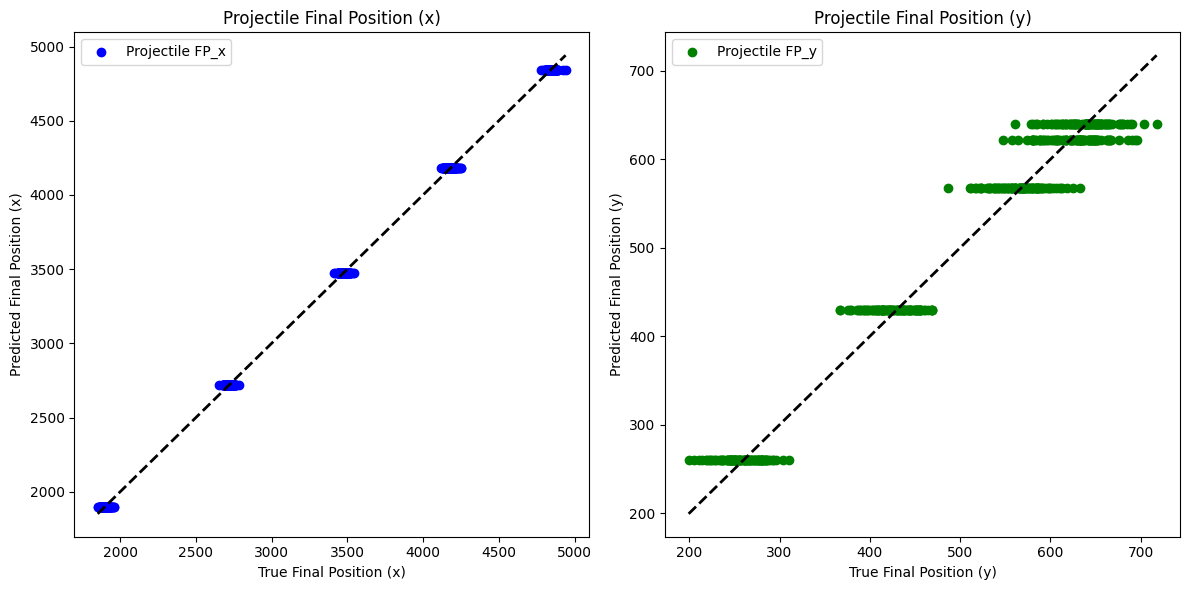

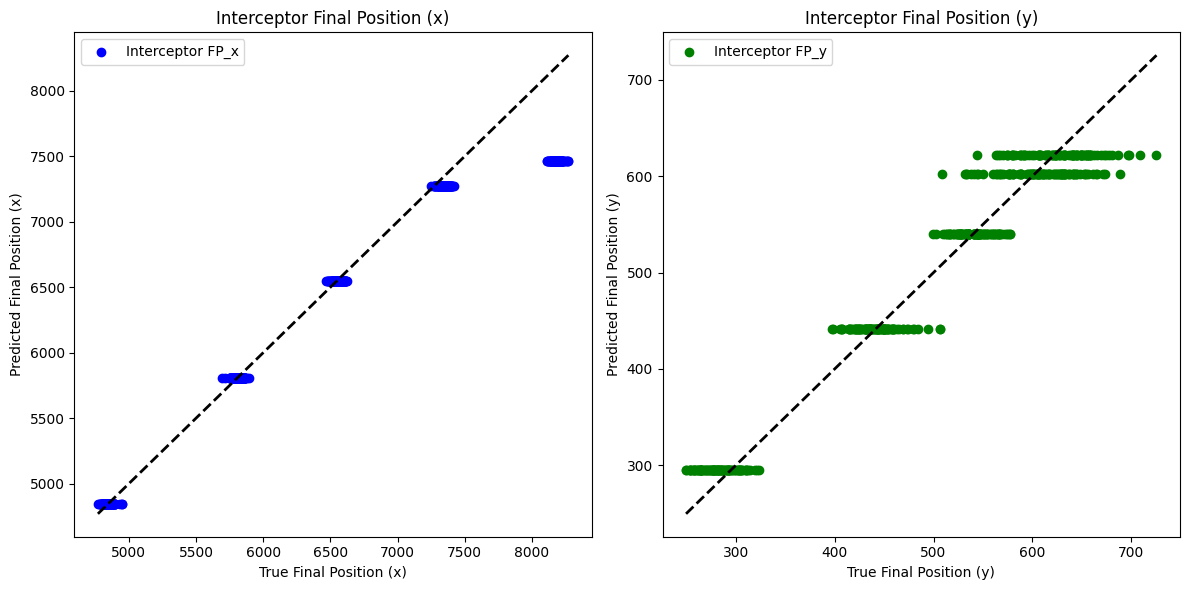

In [9]:
import matplotlib.pyplot as plt

# Initialize lists to store true and predicted final positions
true_fp_x = []
true_fp_y = []
pred_fp_x = []
pred_fp_y = []

# Extract true and predicted final positions for projectile
for i in range(len(test_data)):
    for t in range(6):  # Time steps 1 to 5, since predictions start from t=1
        true_fp_x.append(test_data.loc[i, f'P_FP_x{t}'])
        true_fp_y.append(test_data.loc[i, f'P_FP_y{t}'])
        pred_fp_x.append(predictions[i][f'P_FP_x{t}'])
        pred_fp_y.append(predictions[i][f'P_FP_y{t}'])

# Plot predicted vs true final positions for projectile (x)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(true_fp_x, pred_fp_x, c='blue', label='Projectile FP_x')
plt.plot([min(true_fp_x), max(true_fp_x)], [min(true_fp_x), max(true_fp_x)], 'k--', lw=2)
plt.xlabel('True Final Position (x)')
plt.ylabel('Predicted Final Position (x)')
plt.title('Projectile Final Position (x)')
plt.legend()

# Plot predicted vs true final positions for projectile (y)
plt.subplot(1, 2, 2)
plt.scatter(true_fp_y, pred_fp_y, c='green', label='Projectile FP_y')
plt.plot([min(true_fp_y), max(true_fp_y)], [min(true_fp_y), max(true_fp_y)], 'k--', lw=2)
plt.xlabel('True Final Position (y)')
plt.ylabel('Predicted Final Position (y)')
plt.title('Projectile Final Position (y)')
plt.legend()

plt.tight_layout()
plt.show()

# Repeat the same for the interceptor
true_I_fp_x = []
true_I_fp_y = []
pred_I_fp_x = []
pred_I_fp_y = []

for i in range(len(test_data)):
    for t in range(6):  # Time steps 1 to 5
        true_I_fp_x.append(test_data.loc[i, f'I_FP_x{t}'])
        true_I_fp_y.append(test_data.loc[i, f'I_FP_y{t}'])
        pred_I_fp_x.append(predictions[i][f'I_FP_x{t}'])
        pred_I_fp_y.append(predictions[i][f'I_FP_y{t}'])

# Plot predicted vs true final positions for interceptor (x)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(true_I_fp_x, pred_I_fp_x, c='blue', label='Interceptor FP_x')
plt.plot([min(true_I_fp_x), max(true_I_fp_x)], [min(true_I_fp_x), max(true_I_fp_x)], 'k--', lw=2)
plt.xlabel('True Final Position (x)')
plt.ylabel('Predicted Final Position (x)')
plt.title('Interceptor Final Position (x)')
plt.legend()

# Plot predicted vs true final positions for interceptor (y)
plt.subplot(1, 2, 2)
plt.scatter(true_I_fp_y, pred_I_fp_y, c='green', label='Interceptor FP_y')
plt.plot([min(true_I_fp_y), max(true_I_fp_y)], [min(true_I_fp_y), max(true_I_fp_y)], 'k--', lw=2)
plt.xlabel('True Final Position (y)')
plt.ylabel('Predicted Final Position (y)')
plt.title('Interceptor Final Position (y)')
plt.legend()

plt.tight_layout()
plt.show()


C:\Users\suvar\AppData\Local\Temp\ipykernel_7116\2130091946.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


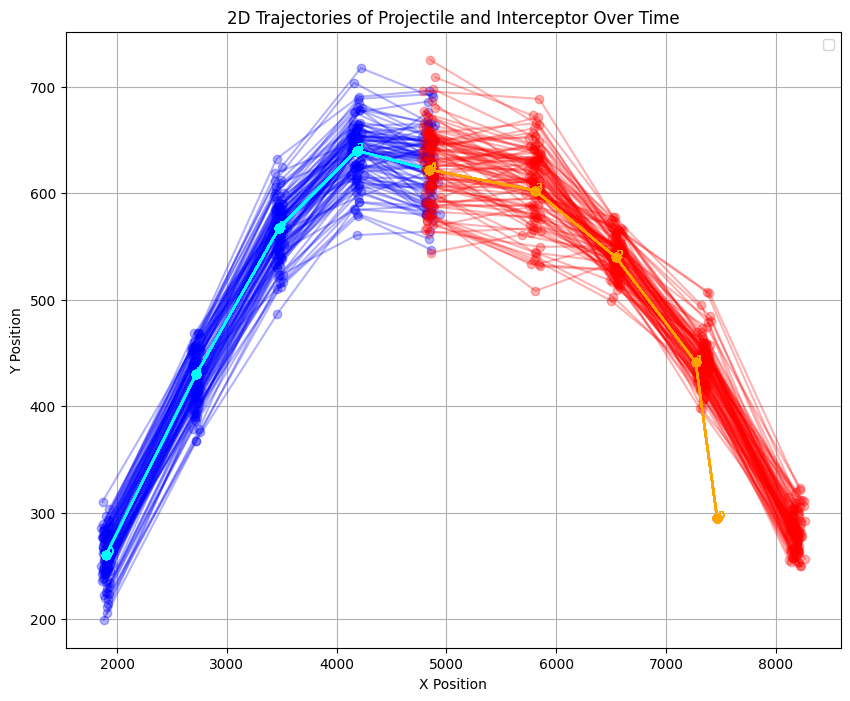

In [10]:
import matplotlib.pyplot as plt

# Function to plot 2D trajectories (X and Y positions over time)
def plot_2d_trajectories(data, x_columns, y_columns, label, color, mean=False): 
    if mean:
        # Extract the mean values for X and Y positions over time slices
        x_values = data[x_columns].mean(axis=0)
        y_values = data[y_columns].mean(axis=0)
        
        # Plot the mean trajectory
        plt.plot(x_values, y_values, marker='o', color=color, label=label)
        
        # Annotate each point with the corresponding time slice
        for i, time_slice in enumerate(x_columns):
            plt.text(x_values[i], y_values[i], f'{i}', fontsize=12)
    else:
        # Plot all individual trajectories
        for i in range(len(data)):
            x_values = data.loc[i, x_columns]
            y_values = data.loc[i, y_columns]
            plt.plot(x_values, y_values, marker='o', color=color, alpha=0.3)  # Use alpha for transparency


# Function to handle predicted data (from the predictions list)
def plot_predicted_trajectories(predictions, x_columns, y_columns, label, color):
    for i in range(len(predictions)):
        x_values = [predictions[i][col] for col in x_columns]
        y_values = [predictions[i][col] for col in y_columns]
        plt.plot(x_values, y_values, marker='o', color=color, alpha=0.3)  # Use alpha for transparency
        # Optionally annotate each point with the corresponding time slice
        for j in range(len(x_values)):
            plt.text(x_values[j], y_values[j], f'{j}', fontsize=8, color=color)


# Define the columns for FPS and IPS (both X and Y positions) for projectiles and interceptors
projectile_fps_x = [f'P_FP_x{i}' for i in range(1, 6)]  # Time slices 1 to 5
projectile_fps_y = [f'P_FP_y{i}' for i in range(1, 6)]
interceptor_fps_x = [f'I_FP_x{i}' for i in range(1, 6)]
interceptor_fps_y = [f'I_FP_y{i}' for i in range(1, 6)]

projectile_ips_x = [f'P_IP_x{i}' for i in range(6)]  # Time slices 0 to 5
projectile_ips_y = [f'P_IP_y{i}' for i in range(6)]
interceptor_ips_x = [f'I_IP_x{i}' for i in range(6)]
interceptor_ips_y = [f'I_IP_y{i}' for i in range(6)]

# Plot the X and Y 2D trajectory for both projectile and interceptor
plt.figure(figsize=(10, 8))
plt.title('2D Trajectories of Projectile and Interceptor Over Time')
plt.xlabel('X Position')
plt.ylabel('Y Position')

# Plot true projectile trajectory (FPS)
plot_2d_trajectories(test_data, projectile_fps_x, projectile_fps_y, "Projectile (FPS)", "blue")

# Plot predicted projectile trajectory (FPS)
plot_predicted_trajectories(predictions, projectile_fps_x, projectile_fps_y, "Predicted Projectile (FPS)", "cyan")

# Plot true interceptor trajectory (FPS)
plot_2d_trajectories(test_data, interceptor_fps_x, interceptor_fps_y, "Interceptor (FPS)", "red")

# Plot predicted interceptor trajectory (FPS)
plot_predicted_trajectories(predictions, interceptor_fps_x, interceptor_fps_y, "Predicted Interceptor (FPS)", "orange")

# # Plot true projectile trajectory (IPS)
# plot_2d_trajectories(test_data, projectile_ips_x, projectile_ips_y, "Projectile (IPS)", "#add8e6", mean=True)

# # Plot true interceptor trajectory (IPS)
# plot_2d_trajectories(test_data, interceptor_ips_x, interceptor_ips_y, "Interceptor (IPS)", "#FF7F7F", mean=True)

plt.legend()
plt.grid(True)
plt.show()